In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


number_of_matche_type=6
df = pd.read_csv(r'E:\fucalty\project\selected 3\train_V2.csv')
df_test = pd.read_csv(r'E:\fucalty\project\selected 3\test_V2.csv')
matche_types = df.matchType.unique()[:number_of_matche_type]
df = df[:][df['matchType'].isin(matche_types)]
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
df = df.dropna()
print ('number of obersation is ',df.shape[0])
print ('number of feature is ',df.shape[1])

number of obersation is  4411698
number of feature is  29


# Apply subset Selection 

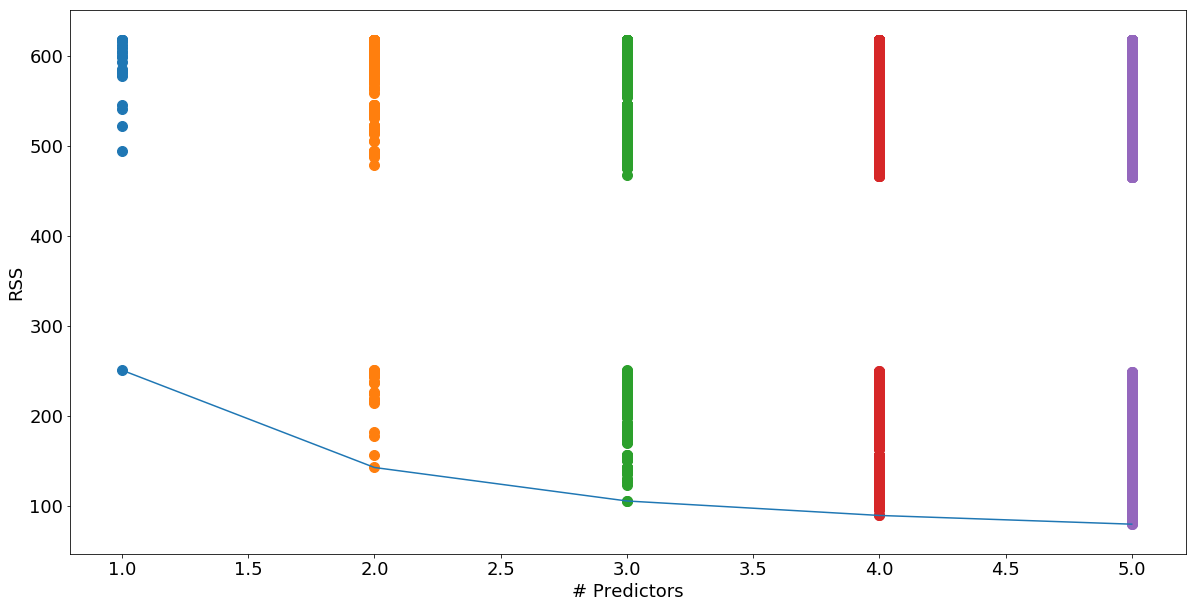

In [6]:
import itertools
import time
import statsmodels.api as sm
number_of_predectors=5
pubg_df = pd.read_csv(r'E:\fucalty\project\selected 3\train_20_match.csv')
y = pubg_df.winPlacePerc
X = pubg_df.drop(['winPlacePerc'], axis=1).astype('float64')


def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def getBest(k):
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    # Return the best model, along with some other useful information about the model
    return (best_model,models)

# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])
models=[]
tic = time.time()
for i in range(1,number_of_predectors+1):
    model_struc=getBest(i)
    models_best.loc[i] = model_struc[0]
    x=[]
    for j in np.arange(model_struc[1].shape[0]):
        x.append(i)
    models.append((x,model_struc[1]))




models_best.apply(lambda row: row[1].rsquared, axis=1)
for model in models:
    model[1].apply(lambda row: row[1].rsquared, axis=1)


##################plot
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})



# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
for model in models:

    plt.scatter(np.array(model[0]),model[1]["RSS"])

plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.show()


# visualization



# start seperate feature to 7 Region 

#1 - Ids -> Id(players)/groupId/matchId
#2 - Match Stats -> matchDuration/matchType/numGroups
#3 - Kill Counts -> DBNOs(knocks)/kills/assists/killStreaks/ headshotKills/roadKills/teamKills
#4 - In Game Stats -> boosts/heals/revives/vehicleDestroys/ weaponsAcquired
#5 - Distances -> longestKill/swimDistance/rideDistance/ walkDistance
#6 - Points -> damageDealt/killPoints/winPoints/rankPoints
#7 - Performance -> killPlace/maxPlace/winPlacePerc


# Match Stats

In [13]:
df_matches=df[['matchId','matchType','matchDuration','numGroups']].drop_duplicates(subset=['matchId'])

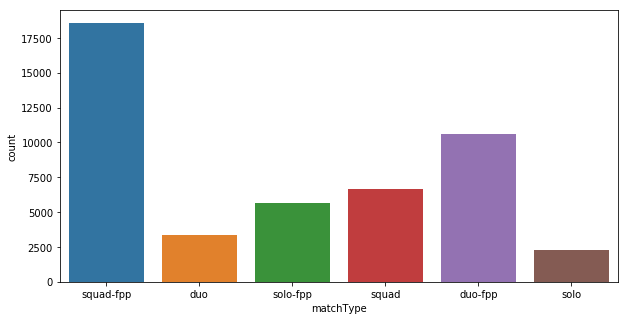

In [15]:
fig, axs = plt.subplots(figsize=(10,5))
sns.countplot(x="matchType", data=df_matches,ax=axs)
plt.show()

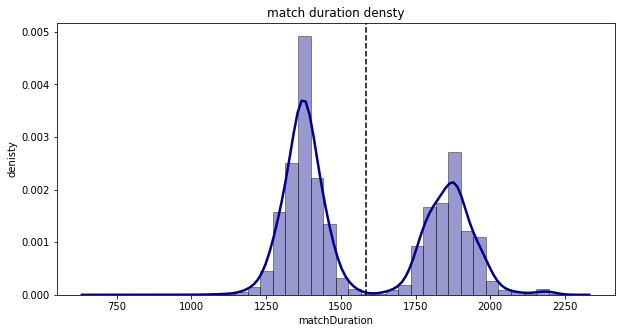

In [9]:


#plot denisty of matchDuration
fig, axs = plt.subplots(figsize=(10,5))
sns.distplot(df_matches['matchDuration'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2.5},ax=axs)
plt.axvline(x=df_matches['matchDuration'].mean(),color='black', linestyle='--')
plt.title('match duration densty')
plt.ylabel('denisty')
plt.show()

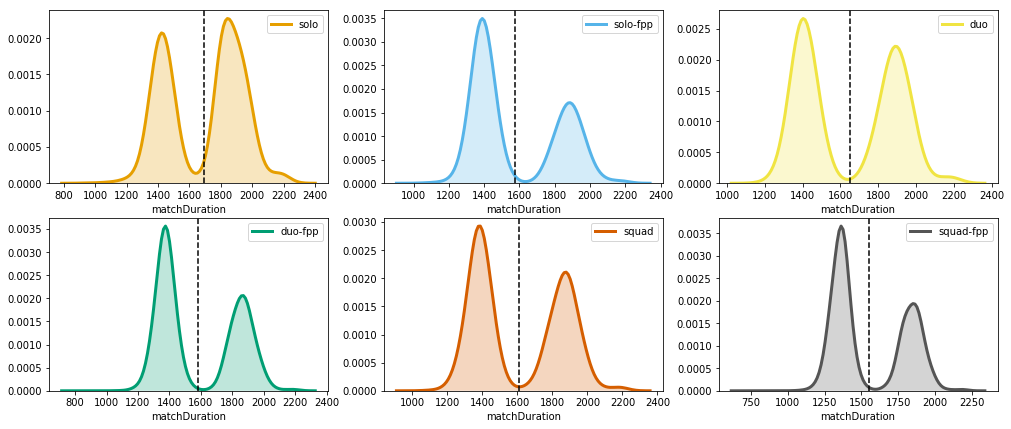

In [10]:
#plot density of match duration for each matchType
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#555555']
matchTypes = ['solo','solo-fpp','duo', 'duo-fpp','squad','squad-fpp']
X=[]
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(17,7))
axc=[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
for i in range(len(matchTypes)):
    ax =sns.kdeplot(df_matches[df_matches['matchType']==matchTypes[i]]['matchDuration'],color=colors[i], label=matchTypes[i],linewidth=3, shade=True ,ax=axes[axc[i][0]][axc[i][1]])
    ax.set(xlabel='matchDuration')
    ax.axvline(x=df_matches[df_matches['matchType']==matchTypes[i]]['matchDuration'].mean(),color='black', linestyle='--')

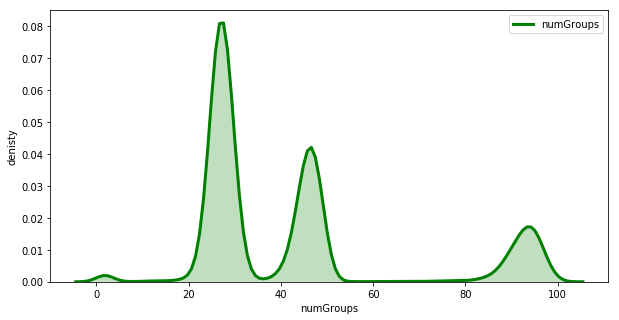

In [11]:
fig, axs = plt.subplots(figsize=(10,5))
ax=sns.kdeplot(df_matches['numGroups'] ,color='green', shade=True,linewidth=3,ax=axs)
ax.set(xlabel='numGroups',ylabel='denisty')
plt.show()

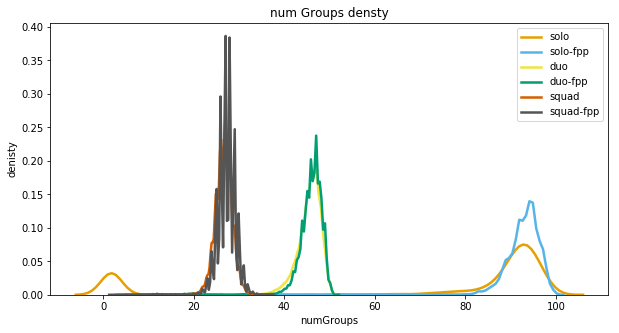

In [12]:
fig, axs = plt.subplots(figsize=(10,5))
for i in range(len(matchTypes)):
    
    ax=sns.distplot(df_matches[df_matches['matchType']==matchTypes[i]]['numGroups'], hist=False, kde=True, 
             bins=int(180/5), color = colors[i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2.5},label=matchTypes[i],ax=axs)

plt.title('num Groups densty')
plt.ylabel('denisty')
plt.show()

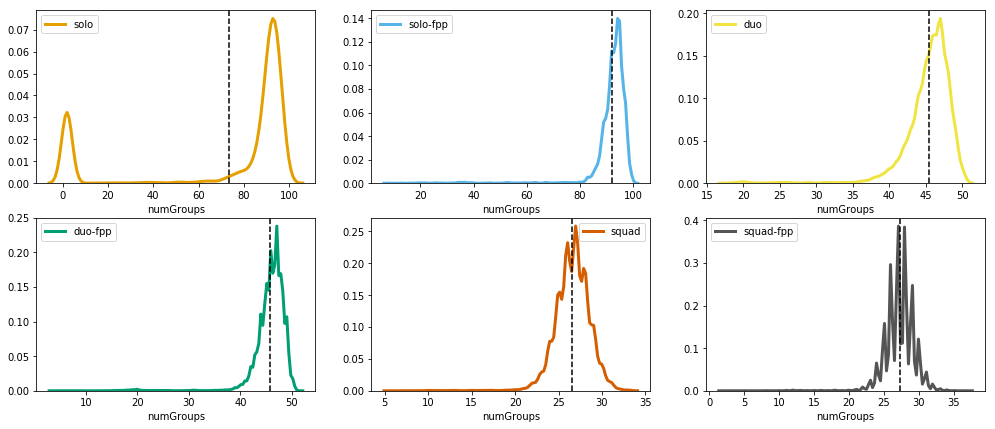

In [13]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(17,7))
axc=[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
for i in range(len(matchTypes)):
    
    ax=sns.distplot(df_matches[df_matches['matchType']==matchTypes[i]]['numGroups'], hist=False, kde=True, 
             bins=int(180/5), color = colors[i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3},ax=axes[axc[i][0]][axc[i][1]],label=matchTypes[i])
    
    ax.axvline(x=df_matches[df_matches['matchType']==matchTypes[i]]['numGroups'].mean(),color='black', linestyle='--')

# Kill Counts

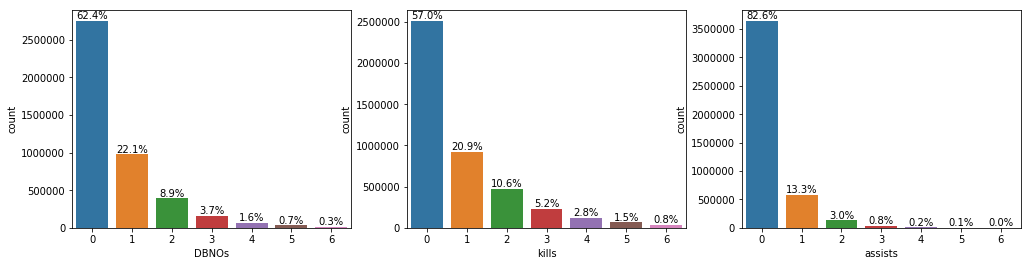

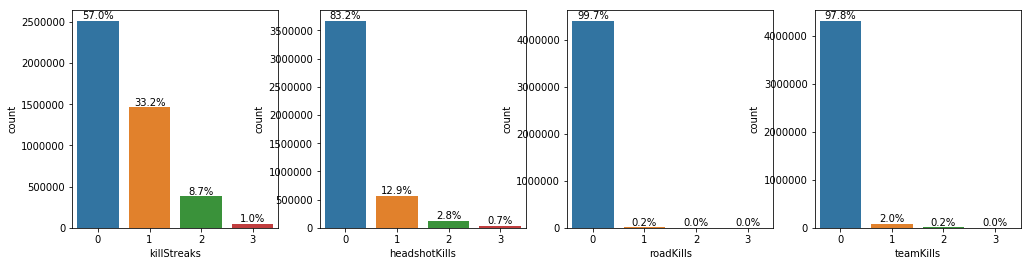

In [14]:
ncount = len(df)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(17,4))
fig2, axes2 = plt.subplots(nrows=1,ncols=4,figsize=(17,4))
kill_features=['DBNOs','kills','assists','killStreaks', 'headshotKills','roadKills','teamKills']
for i in range(3):
    ax=sns.countplot(x=kill_features[i], data=df,ax=axes[i],order=df[kill_features[i]].value_counts().iloc[:7].index)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

for i in range(4):
    ax=sns.countplot(x=kill_features[i+3], data=df,ax=axes2[i],order=df[kill_features[i]].value_counts().iloc[:4].index)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
plt.show()

# In Game Stats

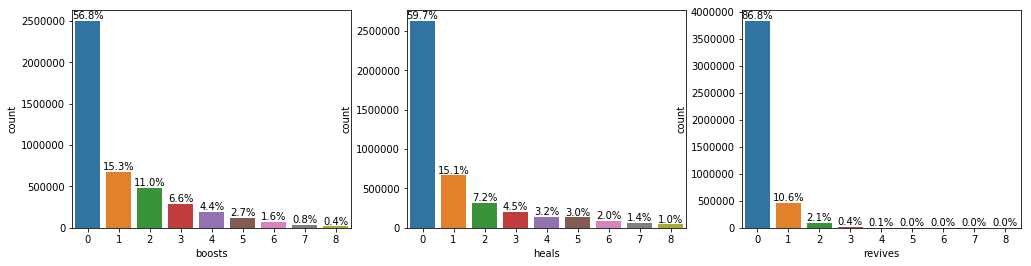

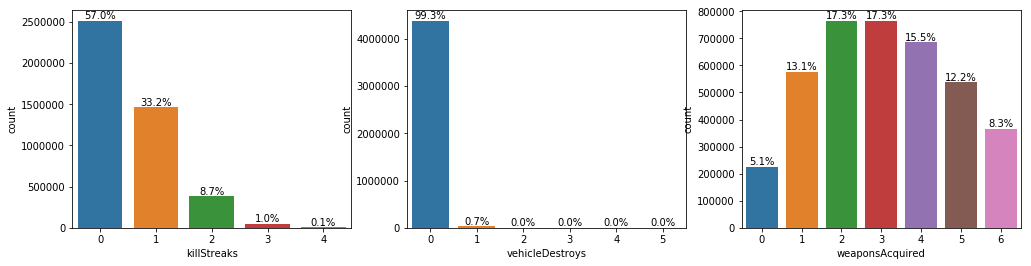

In [15]:
ncount = len(df)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(17,4))
fig2, axes2 = plt.subplots(nrows=1,ncols=3,figsize=(17,4))
game_state_features=[ 'boosts','heals','revives','killStreaks', 'vehicleDestroys','weaponsAcquired']
for i in range(3):
    ax=sns.countplot(x=game_state_features[i], data=df,ax=axes[i],order=df[game_state_features[i]].value_counts().iloc[:9].index)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

for i in range(3):
    ax=sns.countplot(x=game_state_features[i+3], data=df,ax=axes2[i],order=df[game_state_features[i]].value_counts().iloc[:5+i].index)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
plt.show()

# Distances

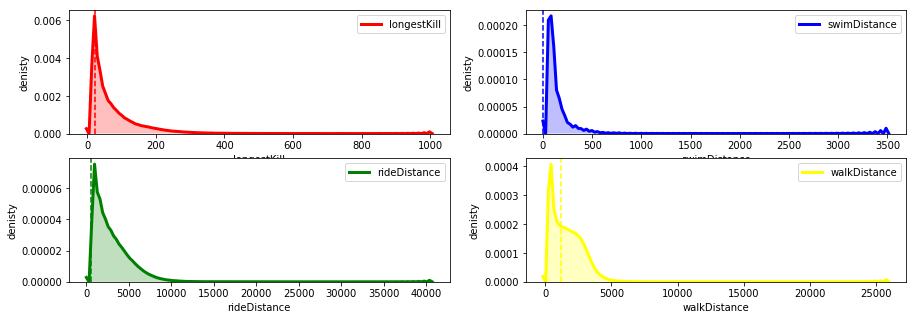

In [16]:
#plot density of match duration for each matchType
colors = ['red', 'blue', 'green', 'yellow']
distances = ['longestKill','swimDistance','rideDistance', 'walkDistance']
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,5))
axc=[(0,0),(0,1),(1,0),(1,1)]
for i in range(len(distances)):
    ax=sns.kdeplot(df[distances[i]],color=colors[i], shade=True,linewidth=3,ax=axes[axc[i][0],axc[i][1]])
    ax.axvline(x=df[distances[i]].mean(),color=colors[i], linestyle='--')
    ax.set(xlabel=distances[i], ylabel='denisty')

# Points

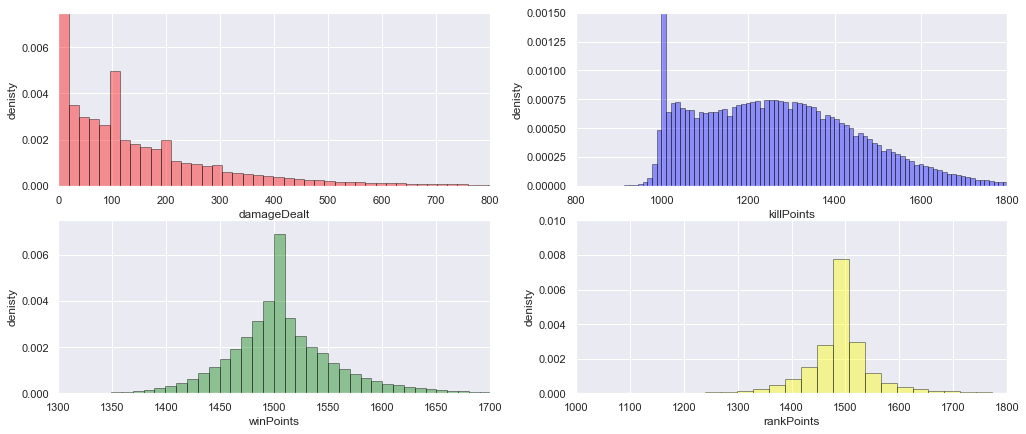

In [333]:
#plot density of match duration for each matchType
colors = ['red', 'blue', 'green', 'yellow']
distances = ['damageDealt','killPoints','winPoints', 'rankPoints']
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(17,7))
axc=[(0,0,0,800,0.0075),(0,1,800,1800,0.0015),(1,0, 1300,1700,0.0075),(1,1,1000,1800,0.01)]
for i in range(len(distances)):
    ax=sns.distplot(df[distances[i]], hist=True, kde=True, 
             bins=int(1000/5), color =colors[i] , 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 0},ax=axes[axc[i][0],axc[i][1]])
    #ax=sns.kdeplot(df[distances[i]],color=colors[i], shade=True,linewidth=3,ax=axes[axc[i][0],axc[i][1]])
    ax.set(xlim=(axc[i][2],axc[i][3]),ylim=(0,axc[i][4]))
    
    ax.set(xlabel=distances[i], ylabel='denisty')

# Performance

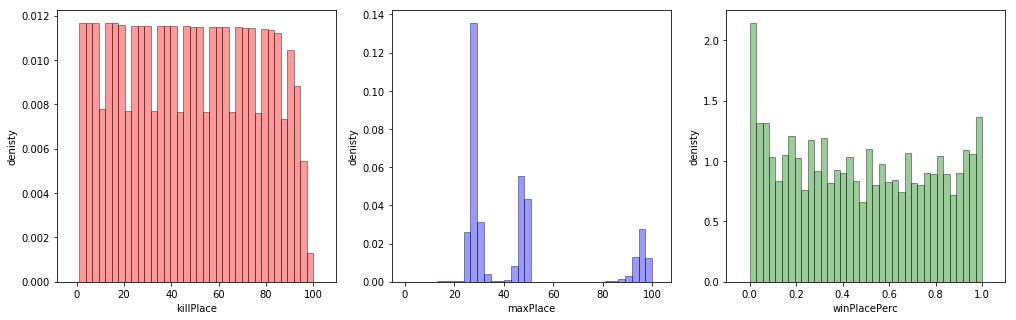

In [17]:
colors = ['red', 'blue', 'green']
Performances = ['killPlace','maxPlace','winPlacePerc']
fig, axes = plt.subplots(ncols=3,figsize=(17,5))
for i in range(len(Performances)):
    ax=sns.distplot(df[Performances[i]], hist=True, kde=True, 
             bins=int(180/5), color = colors[i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 0},label=Performances[i],ax=axes[i])
    ax.set(xlabel=Performances[i], ylabel='denisty')

# correlation between features

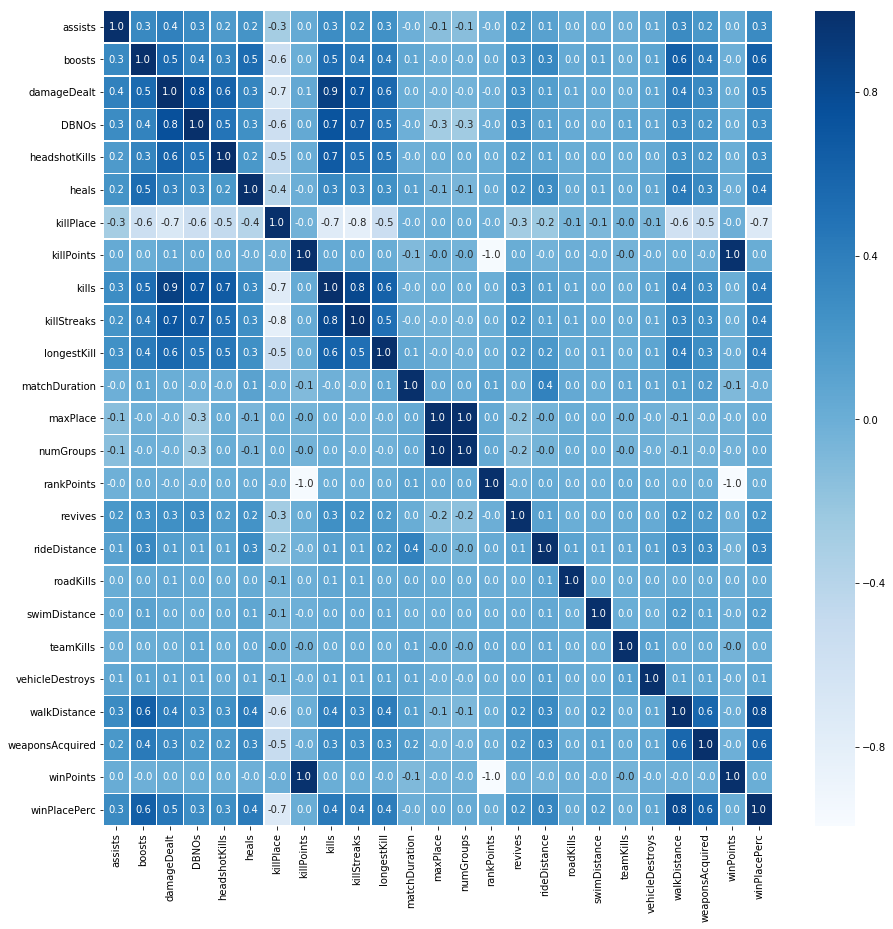

In [3]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap="Blues")
plt.show()

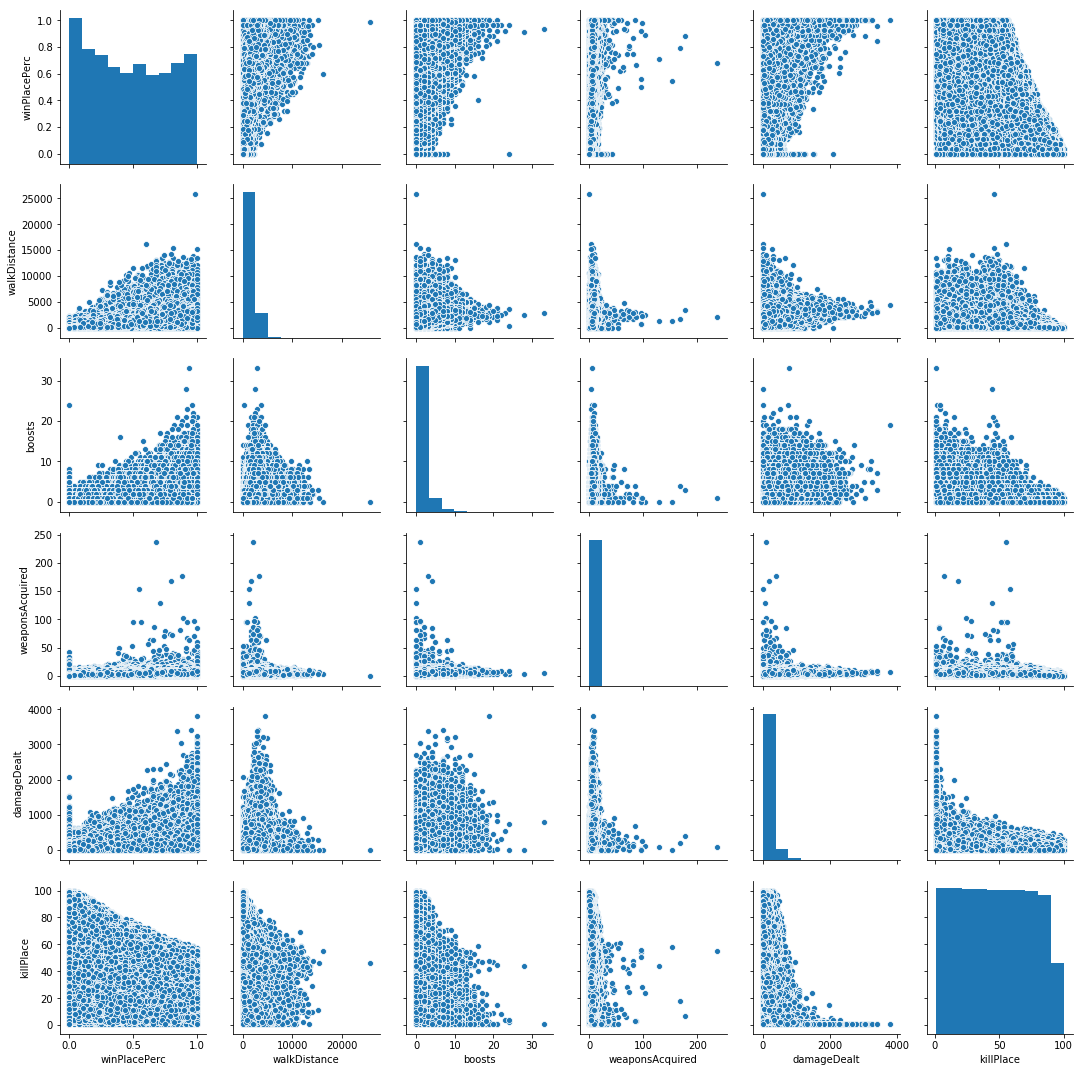

In [5]:
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(df[cols])
plt.show()

# Relation between kills,DBNOs,assists,revives and win pred

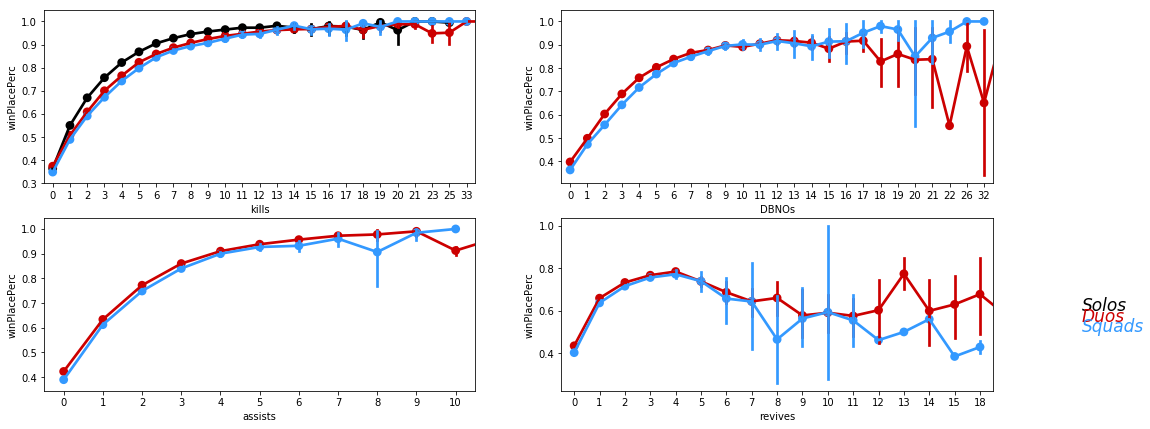

In [14]:
solos = df[df['numGroups']>50]
duos = df[(df['numGroups']>25) & (df['numGroups']<=50)]
squads = df[df['numGroups']<=25]

f,axes = plt.subplots(nrows=2,ncols=2,figsize =(17,7))
axc=[(0,0),(0,1),(1,0),(1,1)]
features=['kills','DBNOs','assists','revives']
for i in range(len(features)):
    if i == 0:
        sns.pointplot(x=features[i],y='winPlacePerc',data=solos,color='black',alpha=0.8,ax=axes[axc[i][0],axc[i][1]])
        sns.pointplot(x=features[i],y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8,ax=axes[axc[i][0],axc[i][1]])
        sns.pointplot(x=features[i],y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8,ax=axes[axc[i][0],axc[i][1]])
        
    else:
        sns.pointplot(x=features[i],y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8,ax=axes[axc[i][0],axc[i][1]])
        sns.pointplot(x=features[i],y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8,ax=axes[axc[i][0],axc[i][1]])
plt.text(20,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(20,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(20,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
    
   
plt.show()

# Relation between swimDistance,rideDistance,walkDistance and win pred

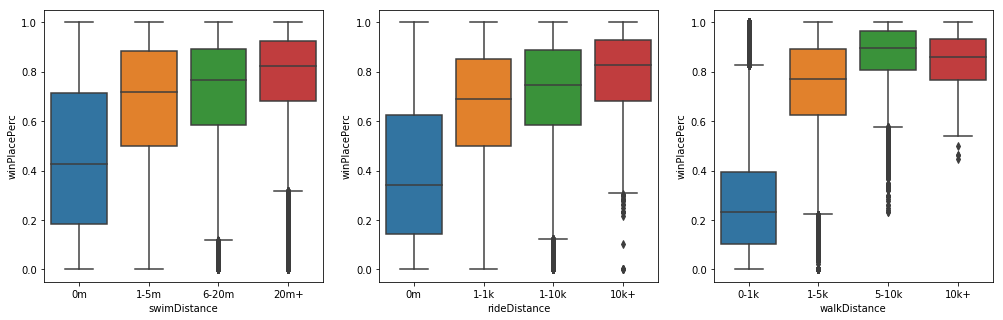

In [15]:
dfdata = df.copy()
dfdata['swimDistance'] = pd.cut(dfdata['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])
dfdata['rideDistance'] = pd.cut(dfdata['rideDistance'], [-1, 0, 1000, 10000,42000], labels=['0m', '1-1k','1-10k', '10k+'])
dfdata['walkDistance'] = pd.cut(dfdata['walkDistance'], [-1, 1000, 5000, 10000,21000], labels=['0-1k', '1-5k','5-10k', '10k+'])
fig, axes = plt.subplots(ncols=3,figsize=(17,5))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=dfdata , ax=axes[0])
sns.boxplot(x="rideDistance", y="winPlacePerc", data=dfdata , ax=axes[1])
sns.boxplot(x="walkDistance", y="winPlacePerc", data=dfdata , ax=axes[2])

plt.show()

# Create Copy from Data

In [4]:
pubg_original_train = df
pubg_original_test = df_test
pubg_ExFet_train=df.copy()
pubg_ExFet_test=df_test.copy()

# Feature engineering and normalization 

In [5]:
# adding players joined in game
pubg_ExFet_train['playerJoined'] = pubg_ExFet_train.groupby('matchId')['matchId'].transform('count')
pubg_ExFet_test['playerJoined']=pubg_ExFet_test.groupby('matchId')['matchId'].transform('count')

# precentage headshot kill for player
pubg_ExFet_train['headShotsPerKill'] = pubg_ExFet_train['headshotKills']/pubg_ExFet_train['kills']
pubg_ExFet_test['headShotsPerKill'] = pubg_ExFet_test['headshotKills']/pubg_ExFet_test['kills']

pubg_ExFet_train['headShotsPerKill'].fillna(0,inplace=True)
pubg_ExFet_test['headShotsPerKill'].fillna(0,inplace=True)

pubg_ExFet_train['headShotsPerKill'].replace(np.inf,0,inplace=True)
pubg_ExFet_test['headShotsPerKill'].replace(np.inf,0,inplace=True)

# total distance travelled
pubg_ExFet_train['distTravelled'] = pubg_ExFet_train['rideDistance']+pubg_ExFet_train['swimDistance']+pubg_ExFet_train['walkDistance']
pubg_ExFet_test['distTravelled'] = pubg_ExFet_test['rideDistance']+pubg_ExFet_test['swimDistance']+pubg_ExFet_test['walkDistance']

# total items used
pubg_ExFet_train['itemsUsed'] = pubg_ExFet_train['heals']+pubg_ExFet_train['boosts']
pubg_ExFet_test['itemsUsed'] = pubg_ExFet_test['heals']+pubg_ExFet_test['boosts']

# team help
pubg_ExFet_train['teamwork']=pubg_ExFet_train['revives']+pubg_ExFet_train['assists']
pubg_ExFet_test['teamwork']=pubg_ExFet_test['revives']+pubg_ExFet_test['assists']

# normalize data
pubg_ExFet_train['killPoints'] = (pubg_ExFet_train['killPoints']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['damageDealt']= (pubg_ExFet_train['damageDealt']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['rankPoints']= (pubg_ExFet_train['rankPoints']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['winPoints']= (pubg_ExFet_train['winPoints']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['kills'] = (pubg_ExFet_train['kills']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['headShotsPerKill']= (pubg_ExFet_train['headShotsPerKill']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['roadKills'] = (pubg_ExFet_train['roadKills']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['teamKills']= (pubg_ExFet_train['teamKills']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['killStreaks'] = (pubg_ExFet_train['killStreaks']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['DBNOs']= (pubg_ExFet_train['DBNOs']*pubg_ExFet_train['playerJoined'])/100
pubg_ExFet_train['assists']= (pubg_ExFet_train['assists']*pubg_ExFet_train['playerJoined'])/100


pubg_ExFet_test['killPoints'] = (pubg_ExFet_test['killPoints']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['damageDealt']= (pubg_ExFet_test['damageDealt']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['rankPoints']= (pubg_ExFet_test['rankPoints']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['winPoints']= (pubg_ExFet_test['winPoints']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['kills'] = (pubg_ExFet_test['kills']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['headShotsPerKill']= (pubg_ExFet_test['headShotsPerKill']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['roadKills'] = (pubg_ExFet_test['roadKills']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['teamKills']= (pubg_ExFet_test['teamKills']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['killStreaks'] = (pubg_ExFet_test['killStreaks']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['DBNOs']= (pubg_ExFet_test['DBNOs']*pubg_ExFet_test['playerJoined'])/100
pubg_ExFet_test['assists']= (pubg_ExFet_test['assists']*pubg_ExFet_test['playerJoined'])/100

# Add map
pubg_ExFet_train['map']=[1 if i>1600 else 2 for i in pubg_ExFet_train['matchDuration']]
pubg_ExFet_test['map']=[1 if i>1600 else 2 for i in pubg_ExFet_test['matchDuration']]

# Analysis for walk distance
pubg_ExFet_train['boostsPerWalkDistance'] = pubg_ExFet_train['boosts']/(pubg_ExFet_train['walkDistance']+1) 
pubg_ExFet_test['boostsPerWalkDistance'] = pubg_ExFet_test['boosts']/(pubg_ExFet_test['walkDistance']+1) 

# log function for spacifc features 
pubg_ExFet_train['vehicleDestroys_log'] = np.log(1+pubg_ExFet_train.vehicleDestroys)
pubg_ExFet_train['teamKills_log']=np.log(1+pubg_ExFet_train.teamKills)
pubg_ExFet_train['swimDistance_log']=np.log(1+pubg_ExFet_train.swimDistance)
pubg_ExFet_train['roadKills_log'] = np.log(1+pubg_ExFet_train.roadKills)

pubg_ExFet_test['vehicleDestroys_log'] = np.log(1+pubg_ExFet_test.vehicleDestroys)
pubg_ExFet_test['swimDistance_log']=np.log(1+pubg_ExFet_test.swimDistance)
pubg_ExFet_test['teamKills_log']=np.log(1+pubg_ExFet_test.teamKills)
pubg_ExFet_test['roadKills_log'] = np.log(1+pubg_ExFet_test.roadKills)


# visualization New features 



#  seperate  New features to 4 Region 

#1 - Match Stats -> playerJoined,map
#2 - KillS -> headShotsPerKill
#3 - player game -> itemsUsed/teamwork
#4 - Distances -> distTravelled/boostsPerWalkDistance

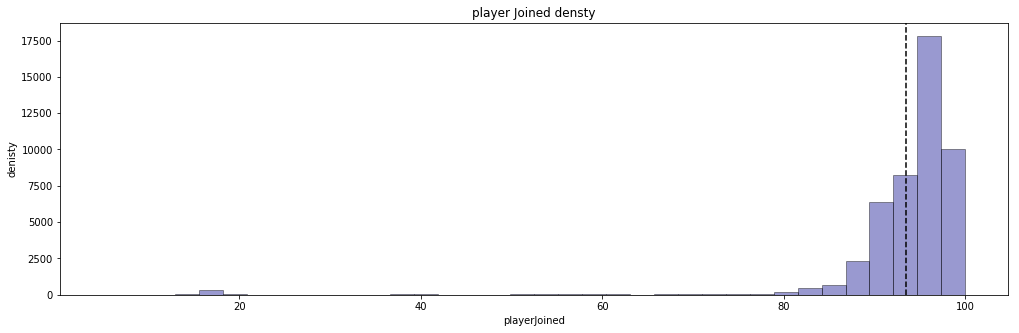

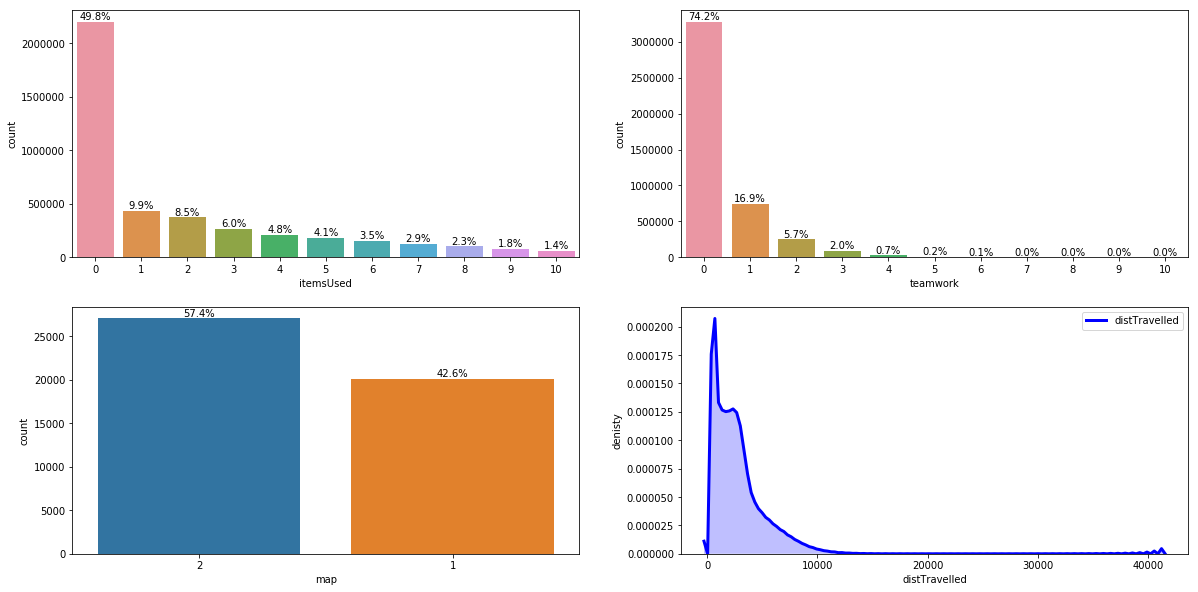

In [81]:
pubg_ExFet_train_matches=pubg_ExFet_train[['matchId','matchType','matchDuration','numGroups','playerJoined','map']].drop_duplicates(subset=['matchId'])
fig, axs = plt.subplots(figsize=(17,5))
sns.distplot(pubg_ExFet_train_matches['playerJoined'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2.5},ax=axs)
plt.axvline(x=pubg_ExFet_train_matches['playerJoined'].mean(),color='black', linestyle='--')
plt.title('player Joined densty')
plt.ylabel('denisty')

ncount = len(pubg_ExFet_train)
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))

game_state_features=[ 'itemsUsed','teamwork']
for i in range(2):
    ax=sns.countplot(x=game_state_features[i], data=pubg_ExFet_train,ax=axes[0,i],order=pubg_ExFet_train[game_state_features[i]].value_counts().iloc[:11].index)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
        
ncount=len(pubg_ExFet_train_matches)

ax=sns.countplot(x='map',data=pubg_ExFet_train_matches,ax=axes[1,0],order=pubg_ExFet_train_matches['map'].value_counts().iloc[:2].index)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

ax=sns.kdeplot(pubg_ExFet_train['distTravelled'],color='blue', shade=True,linewidth=3,ax=axes[1,1])
ax.set(xlabel='distTravelled', ylabel='denisty')
plt.show()

# correlation between new features

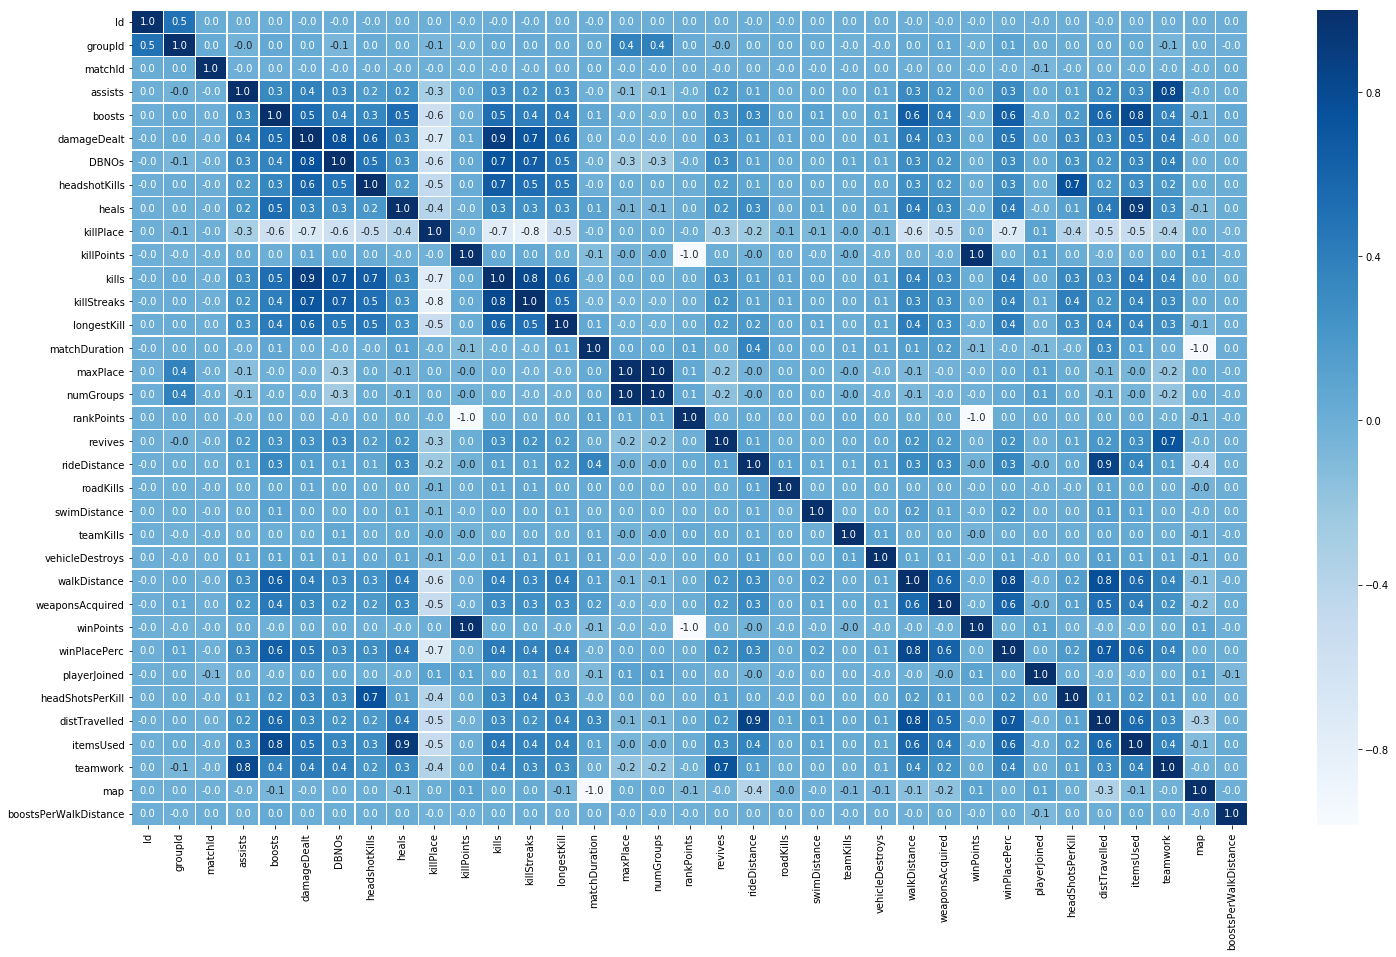

In [61]:
f,ax = plt.subplots(figsize=(25, 15))
sns.heatmap(pubg_ExFet_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap="Blues")
plt.show()

# standardization and categorical encoder

In [6]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
import matplotlib.patches as mpatches
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from keras.models import load_model

for df in [pubg_original_train,pubg_ExFet_train,pubg_original_test,pubg_ExFet_test]:
    df.__delitem__('Id')
    df.__delitem__('groupId')
    df.__delitem__('matchId')
    columns=list(df.columns.values)
    for column in columns:
        if column == 'matchType':
            le = preprocessing.LabelEncoder()
            le.fit(df[column])
            df[column]=le.transform(df[column])
        else:
            df[column]=preprocessing.scale(df[column])

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warning

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warning

# Preparation Data to learning

In [7]:
Y_original=pubg_original_train['winPlacePerc']
pubg_original_train.__delitem__('winPlacePerc')
X_original=pubg_original_train

Y_ExFet=pubg_ExFet_train['winPlacePerc']
pubg_ExFet_train.__delitem__('winPlacePerc')
X_ExFet=pubg_ExFet_train


X_train_ExFet, X_test_ExFet, y_train_ExFet, y_test_ExFet = train_test_split(X_ExFet, Y_ExFet, test_size = 0.2, random_state=42)

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, Y_original, test_size = 0.2, random_state=42)



# Draw whights for 100 lamda for original Dataset and Extra features Dataset and compare errors by Appled Ridge Regression

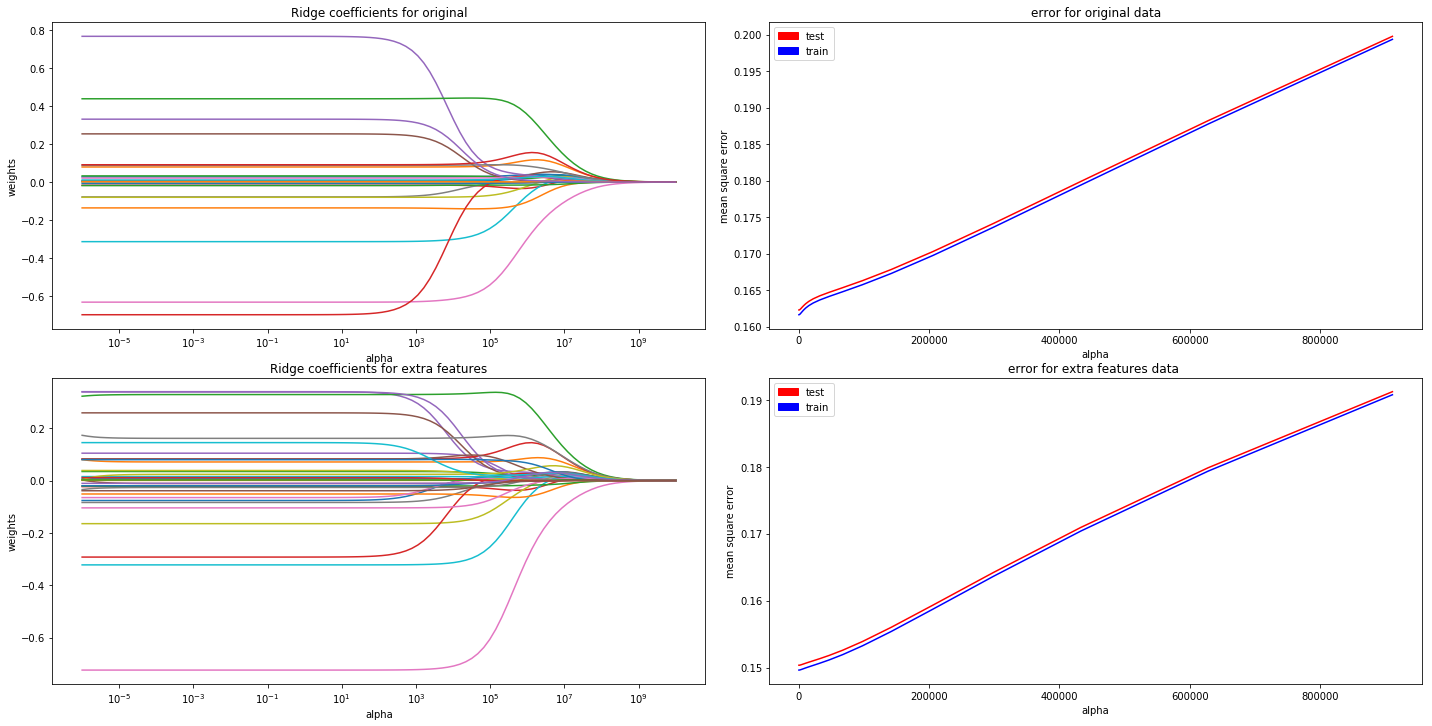

In [14]:
# #############################################################################
# Compute paths
n_alphas = 100
alphas = np.logspace(-6, 10, n_alphas)
coefs_original = []
coefs_ExFet = []
error_original_test= []
error_original_train= []
error_ExFet_test= []
error_ExFet_train= []


for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train_original, y_train_original)
    coefs_original.append(ridge.coef_)
    y_hat_train=ridge.predict(X_train_original)
    y_hat_test=ridge.predict(X_test_original)
    error_original_train.append(mean_squared_error(y_hat_train,y_train_original))
    error_original_test.append(mean_squared_error(y_hat_test,y_test_original))
    
    
for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train_ExFet, y_train_ExFet)
    coefs_ExFet.append(ridge.coef_)
    y_hat_train=ridge.predict(X_train_ExFet)
    y_hat_test=ridge.predict(X_test_ExFet)
    error_ExFet_train.append(mean_squared_error(y_hat_train,y_train_ExFet))
    error_ExFet_test.append(mean_squared_error(y_hat_test,y_test_ExFet))
# #############################################################################
# Display results

coefs_ExFet=[[ x if x<=1 and x>=-1 else 1 for x in coef_ExFet ] for coef_ExFet in coefs_ExFet]
plt.figure(figsize=(20,10))

red_patch = mpatches.Patch(color='red', label='test')
blue_patch = mpatches.Patch(color='blue', label='train')

plt.subplot(221)
ax = plt.gca()
ax.plot(alphas, coefs_original)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients for original')
plt.axis('tight')

plt.subplot(222)
ax1 = plt.gca()
ax1.plot(alphas[:75], error_original_train[:75], color='blue')
ax1.plot(alphas[:75], error_original_test[:75], color='red')
plt.legend(handles=[red_patch,blue_patch])
plt.xlabel('alpha')
plt.ylabel('mean square error')
plt.title('error for original data')
plt.axis('tight')

plt.subplot(223)
ax2 = plt.gca()

ax2.plot(alphas, coefs_ExFet)
ax2.set_xscale('log')
plt.tight_layout()
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients for extra features')
plt.axis('tight')

plt.subplot(224)
ax3 = plt.gca()
ax3.plot(alphas[:75], error_ExFet_train[:75], color='blue')
ax3.plot(alphas[:75], error_ExFet_test[:75], color='red')
plt.legend(handles=[red_patch,blue_patch])
plt.xlabel('alpha')
plt.ylabel('mean square error')
plt.title('error for extra features data ')
plt.axis('tight')
plt.show()

# Create 20 Dataset from Origenal and Extra feature Dataset

In [11]:
n_alphas = 50
alphas = np.logspace(-1, 6, n_alphas)

def CalculateBaisVar(alpha):
    RidgeModels_original=[]
    RidgeModels_ExFet=[]
    kfold = KFold(20, True, 1)
    
    for train, test in kfold.split(X_train_original):
        ridge = linear_model.Ridge(alpha=alpha)
        ridge.fit(X_train_original.iloc[train][:2000], y_train_original.iloc[train][:2000])
        RidgeModels_original.append(ridge)
        
    for train, test in kfold.split(X_train_ExFet):
        ridge = linear_model.Ridge(alpha=alpha)
        ridge.fit(X_train_ExFet.iloc[train][:2000], X_train_ExFet.iloc[train][:2000])
        RidgeModels_ExFet.append(ridge)
    models_vars=[]
    models_bais=[]
    
    for i in range(500):

        predicts=[]
        for model in RidgeModels_original:
            predicts.append(model.predict(X_test_original[i:i+1])[0])
            
        best_predict = RidgeModel_original.predict(X_test_original[i:i+1])[0]
        
        models_vars.append(np.array(predicts).var())
        models_bais.append(pow(np.array(predicts).mean()-best_predict,2))
        
    Bais_original = np.array(models_bais).mean()
    var_original = np.array(models_vars).mean()
    
    models_vars=[]
    models_bais=[]
    
    for i in range(500):
        predicts=[]
        for model in RidgeModels_ExFet:
            predicts.append(model.predict(X_test_ExFet[i:i+1])[0])     
        best_predict = RidgeModel_ExFet.predict(X_test_ExFet[i:i+1])[0]
        models_vars.append(np.array(predicts).var())
        models_bais.append(pow(np.array(predicts).mean()-best_predict,2))
        
    Bais_ExFet = np.array(models_bais).mean()
    var_ExFet = np.array(models_vars).mean()
    
    return (Bais_original,var_original,Bais_ExFet,var_ExFet)
    


Baises_original=[]
vares_original=[]
Baises_ExFet=[]
vares_ExFet=[]

for alpha in alphas:
    Bais_original,var_original,Bais_ExFet,var_ExFet = CalculateBaisVar(alpha)
    
    Baises_original.append(Bais_original)
    vares_original.append(var_original)
    Baises_ExFet.append(Bais_ExFet)
    vares_ExFet.append(var_ExFet)



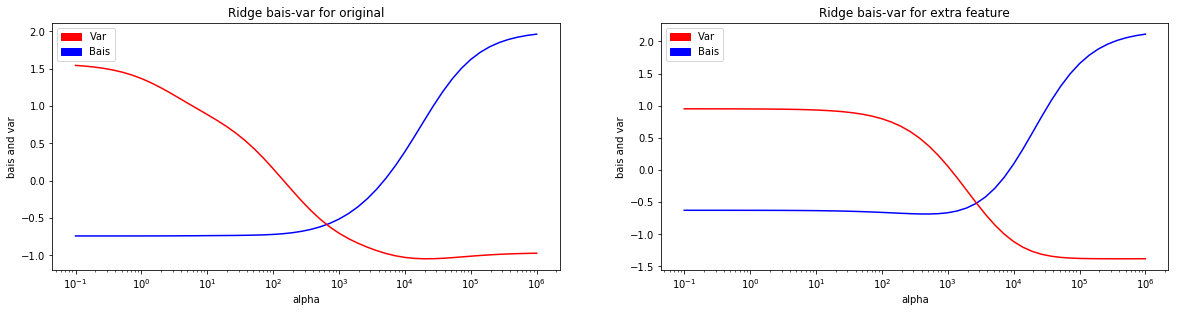

In [12]:

plt.figure(figsize=(20,10))

plt.subplot(221)

ax = plt.gca()
red_patch = mpatches.Patch(color='red', label='Var')
blue_patch = mpatches.Patch(color='blue', label='Bais')

ax.plot(alphas, preprocessing.scale(Baises_original), color='blue' )
ax.plot(alphas, preprocessing.scale(vares_original), color='red')

ax.set_xscale('log')
plt.legend(handles=[red_patch,blue_patch])
plt.xlabel('alpha')
plt.ylabel('bais and var')
plt.title('Ridge bais-var for original')
plt.axis('tight')
plt.subplot(222)
ax2 = plt.gca()
ax2.plot(alphas, preprocessing.scale(Baises_ExFet), color='blue')
ax2.plot(alphas, preprocessing.scale(vares_ExFet), color='red')
ax2.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('bais and var')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Ridge bais-var for extra feature')
plt.axis('tight')

plt.show()

# Drow Total Testing for Cross validation with 5 Fold

In [ ]:
n_alphas = 10
alphas = np.logspace(-6, 10, n_alphas)
kfold = KFold(5, True, 1)
TotalErrors_original=[]
TotalErrors_ExFet=[]
for alpha in alphas:
    TotalError=0
    for train, test in kfold.split(X_train_original):
        ridge = linear_model.Ridge(alpha=alpha)
        ridge.fit(X_train_original.iloc[train], y_train_original.iloc[train])
        y_hat_test=ridge.predict(X_train_original.iloc[test])
        TotalError+=mean_squared_error(y_hat_test,y_train_original.iloc[test])
    TotalErrors_original.append(TotalError)
    TotalError=0
    for train, test in kfold.split(X_train_ExFet):
        ridge = linear_model.Ridge(alpha=alpha)
        ridge.fit(X_train_ExFet.iloc[train], y_train_ExFet.iloc[train])
        y_hat_test=ridge.predict(X_train_ExFet.iloc[test])
        TotalError+=mean_squared_error(y_hat_test,y_train_ExFet.iloc[test])
    TotalErrors_ExFet.append(TotalError)

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(221)

ax = plt.gca()
red_patch = mpatches.Patch(color='red', label='Orginal dataset')
blue_patch = mpatches.Patch(color='blue', label='Extra feature  dataset')

ax.plot(alphas[:50],TotalErrors_ExFet, color='blue' )

ax.set_xscale('log')
plt.legend(handles=[blue_patch])
plt.xlabel('alpha')
plt.ylabel('Total Error')
plt.title('Ridge total error for Extra feature')
plt.axis('tight')

plt.subplot(222)
ax2 = plt.gca()
ax.plot(alphas[:50],TotalErrors_original, color='red' )

ax.set_xscale('log')
plt.legend(handles=[red_patch])
plt.xlabel('alpha')
plt.ylabel('Total Error')
plt.title('Ridge total error for  Orginal')
plt.axis('tight')

plt.show()

# Generate model by Ridge Regression

In [8]:
n_alphas = 10
alphas = np.logspace(2, 5, n_alphas)
RidgeModel_original = RidgeCV(alphas=alphas, cv=5).fit(X_train_original, y_train_original)
RidgeModel_ExFet = RidgeCV(alphas=alphas, cv=5).fit(X_train_ExFet, y_train_ExFet)

# Generate model by lasso Regression

In [9]:
n_alphas = 10
alphas = np.logspace(-1,5,n_alphas)
LassoModel_original = LassoCV(alphas=alphas, cv=5).fit(X_train_original, y_train_original)
LassoModel_ExFet = LassoCV(alphas=alphas, cv=5).fit(X_train_ExFet, y_train_ExFet)

# Generate model by ElasticNet Regression

In [10]:
from sklearn.linear_model import ElasticNetCV
ElasticNetModel_original = ElasticNetCV(alphas=alphas, cv=5).fit(X_train_original, y_train_original)
ElasticNetModel_ExFet = ElasticNetCV(alphas=alphas, cv=5).fit(X_train_ExFet, y_train_ExFet)

# Generate model by polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
n_alphas = 10
alphas = np.logspace(2, 5, n_alphas)
polynomialModel_original = RidgeCV(alphas=alphas, cv=5).fit(poly.fit_transform(X_train_original), y_train_original)
polynomialModel_ExFet = RidgeCV(alphas=alphas, cv=5).fit(poly.fit_transform(X_train_ExFet), y_train_ExFet)

# Generate model by Random Forest Tree 

In [ ]:
ForestModel_original = RandomForestRegressor(min_samples_split=2,n_estimators=50).fit(X_train_original, y_train_original)
ForestModel_ExFet = RandomForestRegressor(min_samples_split=2,n_estimators=50).fit(X_train_ExFet, y_train_ExFet)

# Generate model by neuran network 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint


input_shape_original = X_train_original.shape[1]
# create model
NKmodel_original = Sequential()
NKmodel_original.add(Dense(200, input_dim=input_shape_original, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_original.add(Dense(1,kernel_initializer='normal'))
NKmodel_original.compile(loss='mean_squared_error', optimizer='adam' , metrics=['accuracy'])
NKmodel_original.summary()
NKmodel_original.fit(X_train_original, y_train_original, epochs=15, batch_size=1024 ,validation_split=0.3)

input_shape_ExFet = X_train_ExFet.shape[1]
# create model
NKmodel_ExFet = Sequential()
NKmodel_ExFet.add(Dense(200, input_dim=input_shape_ExFet, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(200, activation='relu', kernel_initializer='normal'))
NKmodel_ExFet.add(Dense(1,kernel_initializer='normal'))
NKmodel_ExFet.compile(loss='mean_squared_error', optimizer='adam' , metrics=['accuracy'])
NKmodel_ExFet.summary()
NKmodel_ExFet.fit(X_train_ExFet, y_train_ExFet, epochs=15, batch_size=1024 ,validation_split=0.3)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 200)               5200      
_________________________________________________________________
dense_20 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_21 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_22 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_23 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_24 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_25 (Dense)             (None, 200)               40200     
__________

In [11]:
NKmodel_original = load_model('NKmodel_original.h5')
NKmodel_ExFet = load_model('NKmodel_ExFet.h5')

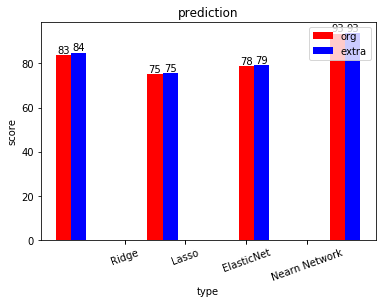

In [19]:
def groupedbarplot(x_data, y_data_list, y_data_names="", title=""):
    total_width = 2
    s=0
    k=0
    label=['org','extra']
    ind_width = total_width / len(y_data_list)
    alteration = np.arange(-(total_width/2), total_width/2, ind_width)
    for i in range(0, len(y_data_list)):
        if(y_data_names[i]=='original'):
            colors='red'
        else:
            colors='blue'
        my_xticks = ['','Ridge','','Lasso','','ElasticNet','','Nearn Network']
        plt.xticks(x_data, my_xticks,rotation=20)
        if((colors=='red' and s==0)):
            s=1
            bar1=plt.bar(x_data[i] + alteration[i], y_data_list[i], color = colors, label = label[0], width = ind_width)
        
        elif((colors=='blue' and k==0)):
            k=1
            bar1=plt.bar(x_data[i] + alteration[i], y_data_list[i], color = colors, label = label[1], width = ind_width)
        else:
            bar1=plt.bar(x_data[i] + alteration[i], y_data_list[i], color = colors, width = ind_width)
        
        for rect in bar1:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

    plt.ylabel("score")
    plt.xlabel("type")
    plt.title(title)
    plt.legend(loc = 'upper right')
y_hat_test=NKmodel_ExFet.predict(X_test_ExFet)
NKmodel_ExFet_score=1- mean_squared_error(y_hat_test,y_test_ExFet)
y_hat_test=NKmodel_original.predict(X_test_original)
NKmodel_original_score=1- mean_squared_error(y_hat_test,y_test_original)
data={'score':[RidgeModel_original.score(X_test_original,y_test_original)*100
               ,RidgeModel_ExFet.score(X_test_ExFet,y_test_ExFet)*100
               ,LassoModel_original.score(X_test_original,y_test_original)*100
               ,LassoModel_ExFet.score(X_test_ExFet,y_test_ExFet)*100
               ,ElasticNetModel_original.score(X_test_original,y_test_original)*100
               ,ElasticNetModel_ExFet.score(X_test_ExFet,y_test_ExFet)*100
               ,NKmodel_original_score*100
               ,NKmodel_ExFet_score*100],'type':[1,1,2,2,3,3,4,4],'exc':['original','ExFet','original','ExFet','original','ExFet','original','ExFet']}

df=pd.DataFrame(data=data)
df['score_fin']=df.groupby(['type','exc'])['score'].transform('mean')
df=df.drop_duplicates(['type','exc'])

groupedbarplot(df['type'],df['score_fin'],df['exc'],"prediction")

